In [1]:
import numpy as np
import pandas  as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
import folium
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

In [2]:
# 한글 폰트 문제 해결 
# matplotlib은 한글 폰트를 지원하지 않음
# os정보
import platform

# font_manager : 폰트 관리 모듈
# rc : 폰트 변경 모듈
from matplotlib import font_manager, rc
# unicode 설정
plt.rcParams['axes.unicode_minus'] = False

if platform.system() == 'Darwin':
    rc('font', family='AppleGothic') # os가 macos
elif platform.system() == 'Windows':
    path = 'c:/Windows/Fonts/malgun.ttf' # os가 windows
    font_name = font_manager.FontProperties(fname=path).get_name()
    rc('font', family=font_name)
else:
    print("Unknown System")

### 날씨 + 대여 / 날씨 + 반납

In [3]:
df_rent=pd.read_csv('../../data/잠실새내대여.csv')
df_return=pd.read_csv('../../data/잠실새내반납.csv')

In [4]:
print(df_rent.columns)
print(df_return.columns)

Index(['대여 대여소번호', '대여 대여소명', '년도', '월', '일', '시간', '휴일여부', '요일', 'date',
       '기온(°C)', '강수량(mm)', '습도(%)', '전운량(10분위)', '시정(10m)', 'PM10', 'PM25'],
      dtype='object')
Index(['반납대여소번호', '반납대여소명', '년도', '월', '일', '시간', '휴일여부', '요일', 'date',
       '기온(°C)', '강수량(mm)', '습도(%)', '전운량(10분위)', '시정(10m)', 'PM10', 'PM25'],
      dtype='object')


In [5]:
rent_count=df_rent.groupby(['월','일','시간']).size().reset_index(name='대여횟수')
return_count=df_return.groupby(['월','일','시간']).size().reset_index(name='반납횟수')

In [6]:
rent_count

,월,일,시간,대여횟수
0,1,1,0,2
1,1,1,1,5
2,1,1,2,1
3,1,1,3,1
4,1,1,4,1
...,...,...,...,...
7472,12,31,19,2
7473,12,31,20,2
7474,12,31,21,1
7475,12,31,22,1


In [7]:
rent_count

,월,일,시간,대여횟수
0,1,1,0,2
1,1,1,1,5
2,1,1,2,1
3,1,1,3,1
4,1,1,4,1
...,...,...,...,...
7472,12,31,19,2
7473,12,31,20,2
7474,12,31,21,1
7475,12,31,22,1


In [8]:

rent_count_weather=pd.merge(rent_count, df_rent[['년도','월', '일', '시간', '휴일여부', '요일','기온(°C)', '강수량(mm)', '습도(%)', '전운량(10분위)', '시정(10m)', 'PM10', 'PM25']], on=['월','일','시간'], how='left').drop_duplicates()

In [9]:
return_count_weather=pd.merge(df_return[['년도','월', '일', '시간', '휴일여부', '요일','기온(°C)', '강수량(mm)', '습도(%)', '전운량(10분위)', '시정(10m)', 'PM10', 'PM25']], return_count,on=['월','일','시간'], how='right').drop_duplicates()

In [10]:
rent_count_weather.reset_index(drop=True, inplace= True)
return_count_weather.reset_index(drop=True, inplace= True)

In [11]:

rent_count_weather['대여'] = rent_count_weather['대여횟수']
rent_count_weather.drop('대여횟수',axis=1, inplace = True)

In [12]:

return_count_weather['반납'] = return_count_weather['반납횟수']
return_count_weather.drop('반납횟수',axis=1, inplace = True)

In [13]:
rent_count_weather.sort_values(['년도','월','일','시간'], inplace= True)
return_count_weather.sort_values(['년도','월','일','시간'], inplace= True)

In [14]:
rent_count_weather['1시간전 강수량'] = rent_count_weather['강수량(mm)'].shift(1)
rent_count_weather.head()

,월,일,시간,년도,휴일여부,요일,기온(°C),강수량(mm),습도(%),전운량(10분위),시정(10m),PM10,PM25,대여,1시간전 강수량
3100,6,1,1,2023,0,3,20.5,0.0,67,10,2000,39.0,24.0,3,NaN
3101,6,1,2,2023,0,3,20.4,0.0,69,10,2000,40.0,27.0,2,0.0
3102,6,1,3,2023,0,3,20.1,0.0,70,10,2000,39.0,24.0,1,0.0
3103,6,1,4,2023,0,3,20.2,0.0,70,10,2000,39.0,21.0,1,0.0
3104,6,1,5,2023,0,3,19.9,0.0,75,10,2000,39.0,24.0,2,0.0


In [15]:
rent_count_weather.tail()

,월,일,시간,년도,휴일여부,요일,기온(°C),강수량(mm),습도(%),전운량(10분위),시정(10m),PM10,PM25,대여,1시간전 강수량
3095,5,31,19,2024,0,4,18.7,1.0,65,8,3671,17.0,4.0,17,0.0
3096,5,31,20,2024,0,4,18.4,0.0,68,8,3216,10.0,1.0,11,1.0
3097,5,31,21,2024,0,4,18.7,0.0,67,9,3449,13.0,4.0,7,0.0
3098,5,31,22,2024,0,4,18.8,0.0,73,10,2528,16.0,11.0,22,0.0
3099,5,31,23,2024,0,4,18.4,0.0,80,10,963,23.0,9.0,10,0.0


In [16]:
rent_count_weather.fillna(0, inplace= True)

In [17]:
rent_count_weather.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7477 entries, 3100 to 3099
Data columns (total 15 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   월          7477 non-null   int64  
 1   일          7477 non-null   int64  
 2   시간         7477 non-null   int64  
 3   년도         7477 non-null   int64  
 4   휴일여부       7477 non-null   int64  
 5   요일         7477 non-null   int64  
 6   기온(°C)     7477 non-null   float64
 7   강수량(mm)    7477 non-null   float64
 8   습도(%)      7477 non-null   int64  
 9   전운량(10분위)  7477 non-null   int64  
 10  시정(10m)    7477 non-null   int64  
 11  PM10       7477 non-null   float64
 12  PM25       7477 non-null   float64
 13  대여         7477 non-null   int64  
 14  1시간전 강수량   7477 non-null   float64
dtypes: float64(5), int64(10)
memory usage: 934.6 KB


In [18]:
jamsil_total=pd.read_csv('../../data/잠실새내통합.csv')

In [19]:
jamsil_total.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120229 entries, 0 to 120228
Data columns (total 17 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   자전거번호     120229 non-null  object 
 1   대여일시      120229 non-null  object 
 2   대여 대여소번호  120229 non-null  int64  
 3   대여 대여소명   120229 non-null  object 
 4   대여거치대     120229 non-null  int64  
 5   반납일시      120229 non-null  object 
 6   반납대여소번호   119977 non-null  float64
 7   반납대여소명    120229 non-null  object 
 8   반납거치대     120229 non-null  object 
 9   이용시간(분)   120229 non-null  int64  
 10  이용거리(M)   120229 non-null  float64
 11  생년        120229 non-null  object 
 12  성별        116945 non-null  object 
 13  이용자종류     120229 non-null  object 
 14  자전거구분     95302 non-null   object 
 15  자치구       119036 non-null  object 
 16  반납 자치구    118922 non-null  object 
dtypes: float64(2), int64(3), object(12)
memory usage: 15.6+ MB


In [20]:
jamsil_total=jamsil_total[(jamsil_total['이용시간(분)'] != 0)&(jamsil_total['이용거리(M)']!=0)]


In [21]:
jamsil_out=jamsil_total[jamsil_total['대여 대여소번호'] ==1222]
jamsil_in=jamsil_total[jamsil_total['반납대여소번호'] ==1222]

In [22]:
jamsil_out.groupby('반납대여소명').size().sort_values(ascending=False)

반납대여소명
잠실새내역 5번 출구 뒤        4743
잠실나들목2(엘스아파트136동)    3508
아시아지하보도 2번 출구        2595
잠실주공5단지1             2562
잠실나들목4               2341
                     ... 
잔디마을 마을버스 정류장           1
신논현역 4번출구               1
군자역 비채온 오피스텔            1
신내동 한살림 중랑지구 앞          1
장충동먹자골목 앞               1
Length: 915, dtype: int64

In [23]:
jamsil_out.groupby('반납대여소번호').size()

반납대여소번호
103.0     1
106.0     5
111.0     5
112.0     3
119.0     2
         ..
5858.0    4
5859.0    1
5862.0    3
5867.0    2
5870.0    1
Length: 905, dtype: int64

In [24]:
print(len(jamsil_in['대여 대여소명'].unique()) )
print(len(jamsil_in['대여 대여소번호'].unique()))

966
957


In [25]:
jamsil_in['대여 대여소명']=jamsil_in['대여 대여소명'].str.replace(' ', "")
jamsil_out['반납대여소명']=jamsil_out['반납대여소명'].str.replace(' ', "")

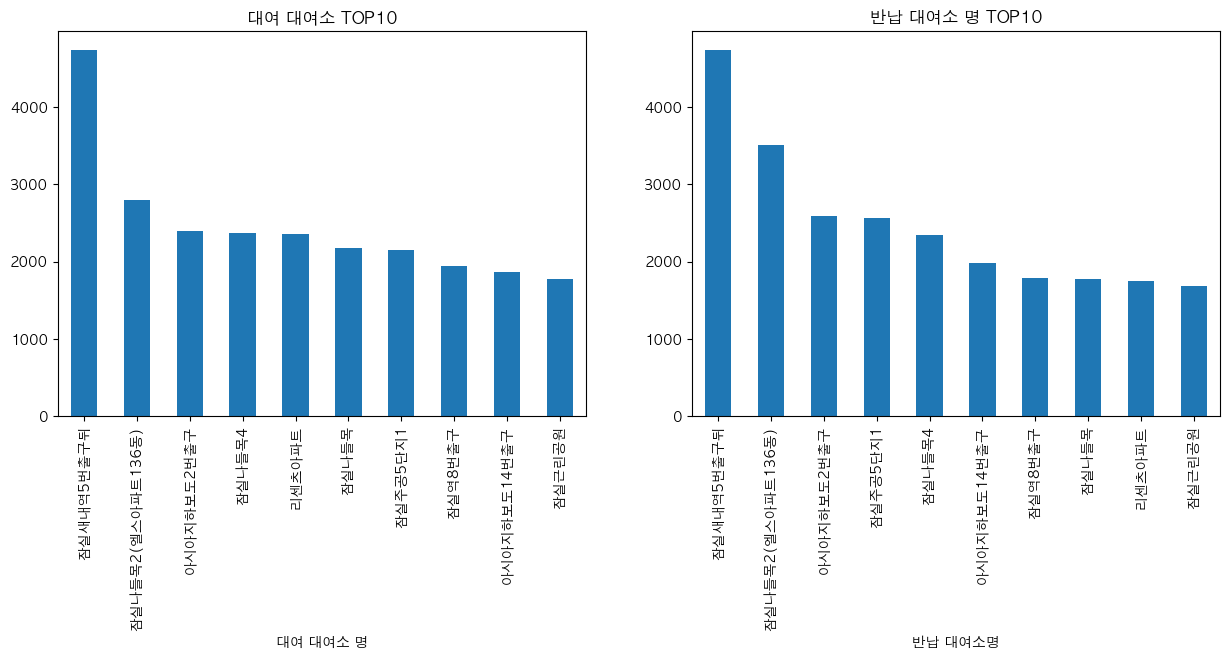

In [26]:

# 타 대여소 -> 잠실새내 반납
fig = plt.figure(figsize=(15,5))
ax1  = fig.add_subplot(1,2,1)
ax2  = fig.add_subplot(1,2,2)

jamsil_in['대여 대여소명'].value_counts().nlargest(10).plot(
    kind='bar',
    ax=ax1, # 위치 지정
)
ax1.set_title('대여 대여소 TOP10')
ax1.set_xlabel('대여 대여소 명')

# 잠실새내 대여-> 타 대여소
# regression 회귀 plot
jamsil_out['반납대여소명'].value_counts().nlargest(10).plot(
    kind='bar',
    ax=ax2, # 위치 지정
)
ax2.set_title('반납 대여소 명 TOP10')
ax2.set_xlabel('반납 대여소명')



plt.show()


In [27]:

# 상위 10개 반납대여소 추출
top_10_stations_out = jamsil_out['반납대여소번호'].value_counts().nlargest(10)
# 위도 경도 데이터가 있는 테이블 (예: station_locations)
station_locations = pd.read_csv('../../data/송파구 대여소 거치대수.csv', index_col=0)




# 잠실새내에서 대여한 경우
top_10_with_locations_out = pd.merge(
    top_10_stations_out.reset_index(),
    station_locations,
    left_on='반납대여소번호',
    right_on='대여소 번호',
    how='left'
)





# 지도 생성 (서울 중심)
m = folium.Map(location=[37.511982, 127.085052], zoom_start=15)

# 각 대여소에 마커 추가
for idx, row in top_10_with_locations_out.iterrows():
    # 반납 대여소 마커
    folium.CircleMarker(
                location=[row['위도'],row['경도']],
                radius=row['count'] / 100,
                popup=folium.Popup(f"대여소번호: {row['대여소']}, 반납 횟수: {row['count']}", max_width=150),
                fill = True,
        ).add_to(m)
folium.Marker(
        location=[37.511982, 127.085052],
        icon=folium.Icon(color="RED")
    ).add_to(m)
# 지도 저장




m

In [28]:

# 상위 10개 반납대여소 추출
top_10_stations_in = jamsil_in['대여 대여소번호'].value_counts().nlargest(10)
# 위도 경도 데이터가 있는 테이블 (예: station_locations)
station_locations = pd.read_csv('../../data/송파구 대여소 거치대수.csv', index_col=0)


# 잠실새내로 반납한 경우
top_10_with_locations_in = pd.merge(
    top_10_stations_in.reset_index(),
    station_locations,
    left_on='대여 대여소번호',
    right_on='대여소 번호',
    how='left'
)



# 지도 생성 (서울 중심)
in_map = folium.Map(location=[37.511982, 127.085052], zoom_start=15)

# 각 대여소에 마커 추가
for idx, row in top_10_with_locations_in.iterrows():
    # 대여 대여소 마커
    folium.CircleMarker(
                location=[row['위도'],row['경도']],
                radius=row['count'] / 100,
                popup=folium.Popup(f"대여소번호: {row['대여소']}, 대여 횟수: {row['count']}", max_width=150),
                fill_color = 'red',
                color='red',
                fill = True
        ).add_to(in_map)
folium.Marker(
        location=[37.511982, 127.085052],
        icon=folium.Icon(color="RED")
    ).add_to(in_map)
# 지도 저장
in_map

-------------
## 그래프

### 대여

In [29]:
rent_count_weather.head(2)

,월,일,시간,년도,휴일여부,요일,기온(°C),강수량(mm),습도(%),전운량(10분위),시정(10m),PM10,PM25,대여,1시간전 강수량
3100,6,1,1,2023,0,3,20.5,0.0,67,10,2000,39.0,24.0,3,0.0
3101,6,1,2,2023,0,3,20.4,0.0,69,10,2000,40.0,27.0,2,0.0


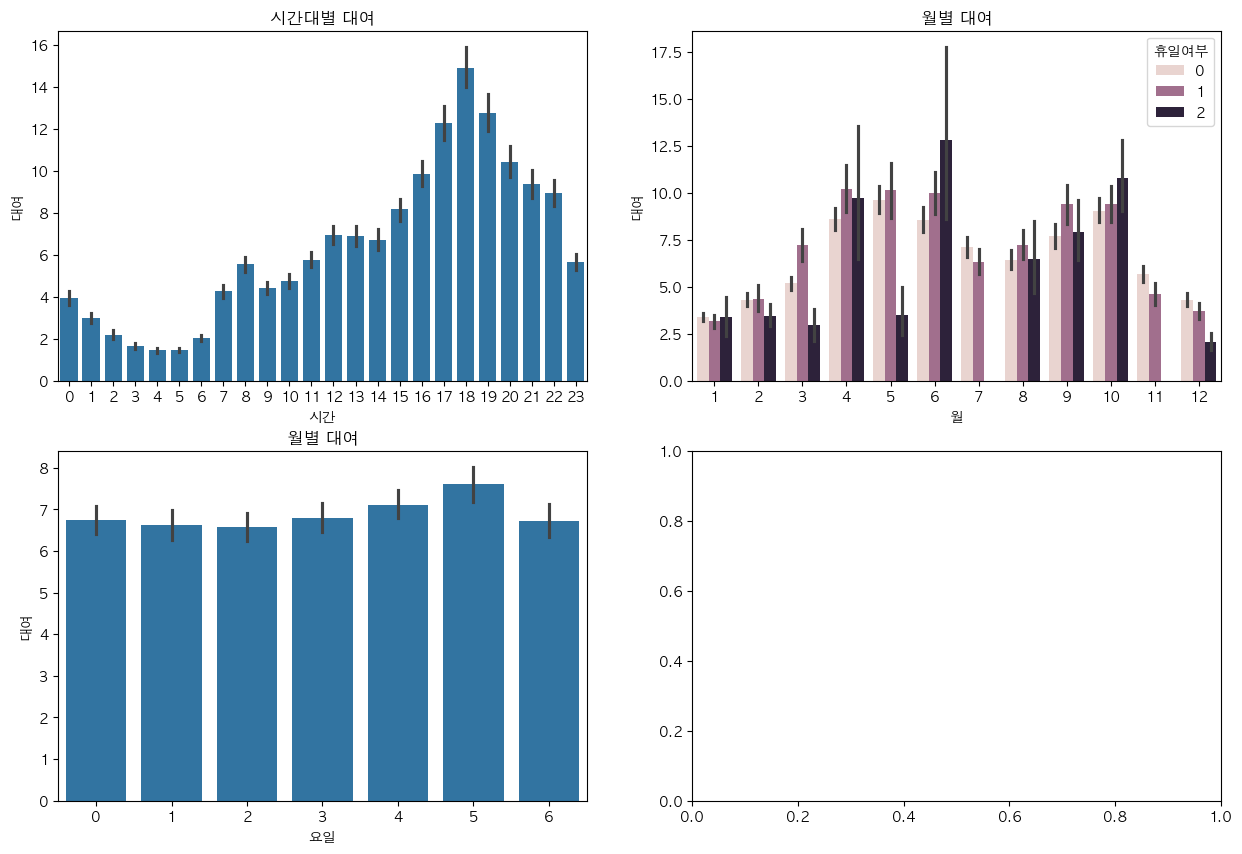

In [30]:
# 스타일 테마 5가지
# darkgrid / whitegrid / dark / white / ticks


fig = plt.figure(figsize=(15,10))
ax1  = fig.add_subplot(2,2,1)
ax2  = fig.add_subplot(2,2,2)
ax3  = fig.add_subplot(2,2,3)
ax4  = fig.add_subplot(2,2,4)

# regression 회귀 plot
sns.barplot(
    x='시간',
    y='대여',
    data= rent_count_weather,
    ax=ax1, # 위치 지정
)
ax1.set_title('시간대별 대여')


sns.barplot(
    x='월',
    y='대여',
    data= rent_count_weather,
    hue= '휴일여부',
    ax=ax2, # 위치 지정
)
ax2.set_title('월별 대여')


sns.barplot(
    x='요일',
    y='대여',
    data= rent_count_weather,
    ax=ax3, # 위치 지정
)
ax3.set_title('월별 대여')


plt.show()


In [31]:
rent_count_weather.columns

Index(['월', '일', '시간', '년도', '휴일여부', '요일', '기온(°C)', '강수량(mm)', '습도(%)',
       '전운량(10분위)', '시정(10m)', 'PM10', 'PM25', '대여', '1시간전 강수량'],
      dtype='object')

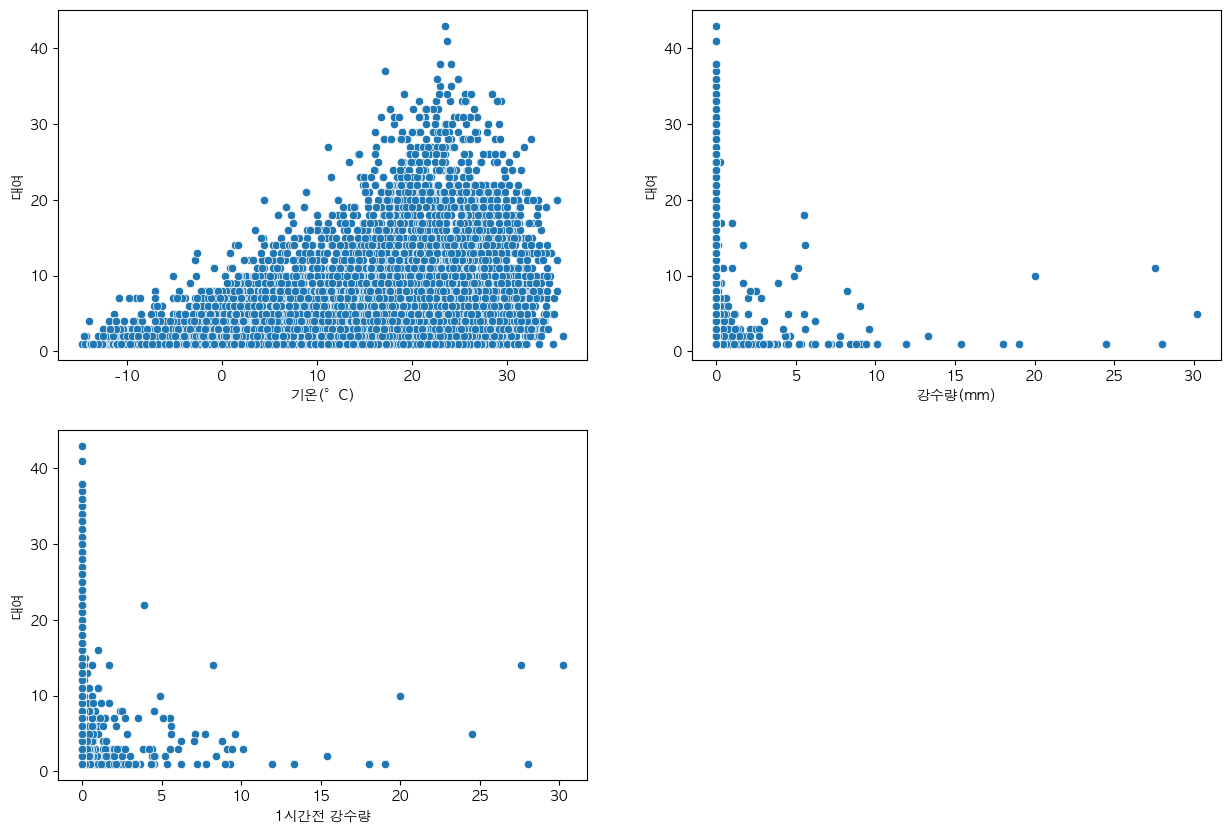

In [32]:
fig = plt.figure(figsize=(15,10))
ax1  = fig.add_subplot(2,2,1)
ax2  = fig.add_subplot(2,2,2)
ax3  = fig.add_subplot(2,2,3)


sns.scatterplot(
    x='기온(°C)',
    y='대여',
    data=rent_count_weather,
    ax=ax1,
)


sns.scatterplot(
    x='강수량(mm)',
    y='대여',
    data=rent_count_weather,
    ax=ax2,
)


sns.scatterplot(
    x='1시간전 강수량',
    y='대여',
    data=rent_count_weather,
    ax=ax3,
)


plt.show()

In [33]:
rent_count_weather.describe()

,월,일,시간,년도,휴일여부,요일,기온(°C),강수량(mm),습도(%),전운량(10분위),시정(10m),PM10,PM25,대여,1시간전 강수량
count,7477.000000,7477.000000,7477.000000,7477.000000,7477.000000,7477.000000,7477.000000,7477.000000,7477.000000,7477.000000,7477.000000,7477.000000,7477.000000,7477.000000,7477.000000
mean,6.516250,15.683697,12.276983,2023.414605,0.369934,3.016852,14.805109,0.086331,66.201418,4.806072,2101.381838,35.029205,18.301556,6.879765,0.086331
std,3.398991,8.871421,6.815769,0.492687,0.573254,1.981923,10.614956,0.935758,17.375979,3.927493,1086.625746,26.237178,11.663424,6.123560,0.935758
min,1.000000,1.000000,0.000000,2023.000000,0.000000,0.000000,-14.700000,0.000000,14.000000,0.000000,24.000000,3.000000,1.000000,1.000000,0.000000
25%,4.000000,8.000000,7.000000,2023.000000,0.000000,1.000000,5.600000,0.000000,54.000000,0.000000,1395.000000,21.000000,10.000000,2.000000,0.000000
50%,6.000000,16.000000,13.000000,2023.000000,0.000000,3.000000,16.500000,0.000000,67.000000,6.000000,2000.000000,30.428571,16.000000,5.000000,0.000000
75%,9.000000,23.000000,18.000000,2024.000000,1.000000,5.000000,23.800000,0.000000,80.000000,9.000000,2667.000000,42.000000,24.000000,9.000000,0.000000
max,12.000000,31.000000,23.000000,2024.000000,2.000000,6.000000,35.800000,30.200000,100.000000,10.000000,5000.000000,487.000000,89.000000,43.000000,30.200000


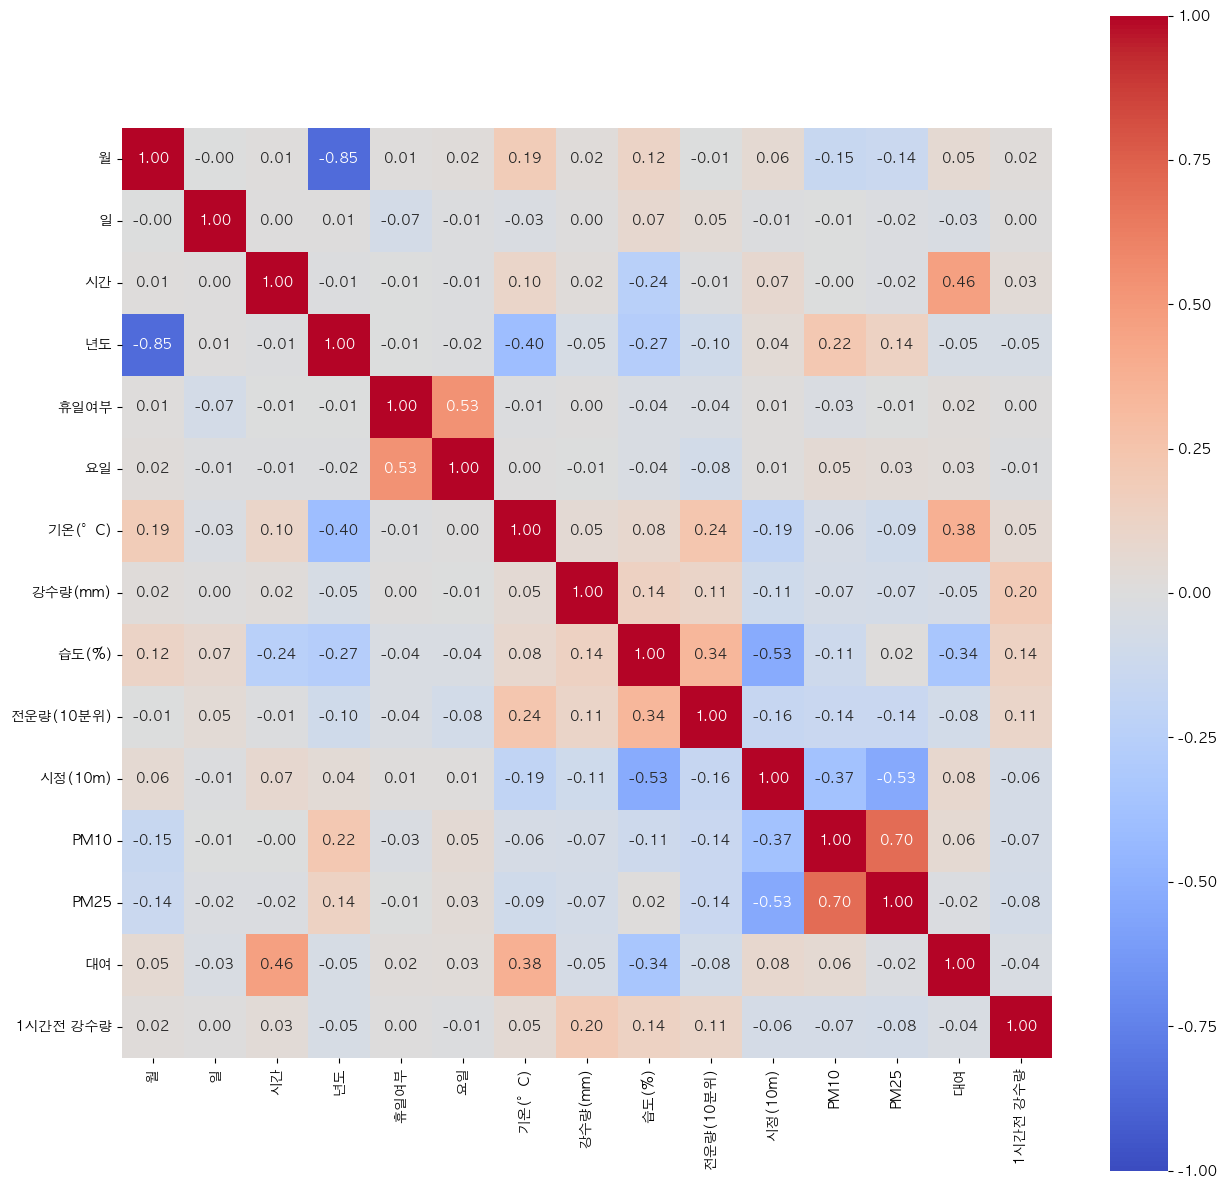

In [34]:
fig = plt.figure(figsize=(15,15))


sns.heatmap(rent_count_weather.corr(numeric_only=True),
            annot=True,  # 각 셀에 숫자 표시
            cmap='coolwarm',  # 색상 맵 설정
            vmin=-1, vmax=1,  # 색상 범위 설정
            center=0,  # 0을 중심으로 색상 대칭
            square=True,  # 정사각형 셀
            fmt='.2f', # 소수점 둘째 자리까지 표시
            ) 


plt.show()

In [35]:
rent_count_weather['계절']=rent_count_weather['월'].map({1:'겨울',2:'겨울',3:'봄',4:'봄',5:'봄',6:'여름',7:'여름',8:'여름',9:'가을',10:'가을',11:'가을',12:'겨울'})
return_count_weather['계절']=return_count_weather['월'].map({1:'겨울',2:'겨울',3:'봄',4:'봄',5:'봄',6:'여름',7:'여름',8:'여름',9:'가을',10:'가을',11:'가을',12:'겨울'})


In [36]:
rent_season=pd.get_dummies(rent_count_weather['계절'])
return_season=pd.get_dummies(return_count_weather['계절'])

In [37]:
rent_count_weather[['봄','여름','가을','겨울']] =rent_season
return_count_weather[['봄','여름','가을','겨울']] =return_season

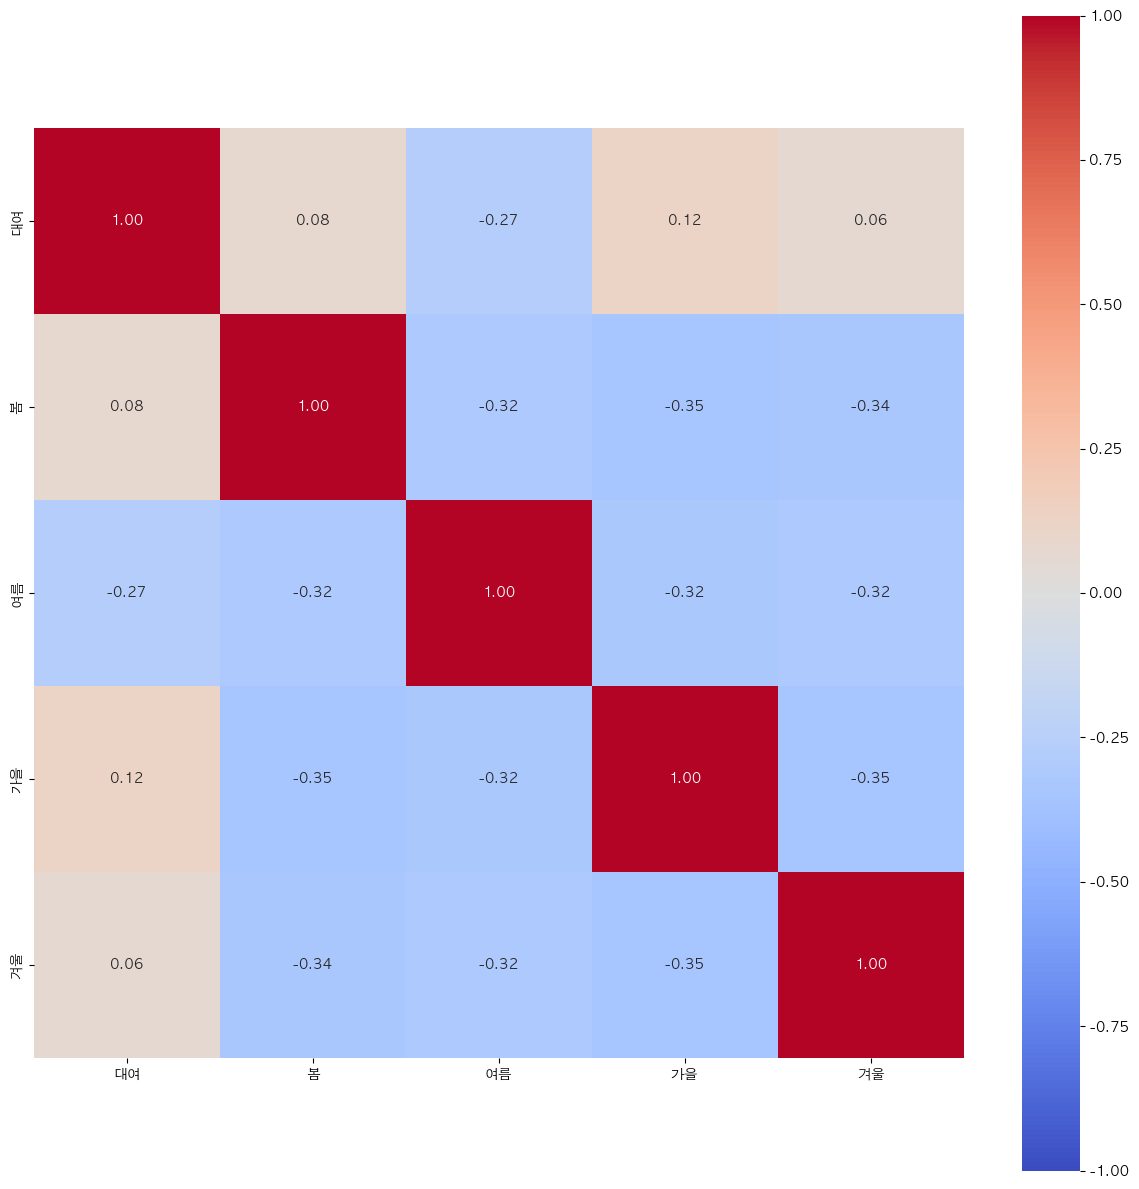

In [38]:
fig = plt.figure(figsize=(15,15))


sns.heatmap(rent_count_weather[['대여','봄','여름','가을','겨울']].corr(),
            annot=True,  # 각 셀에 숫자 표시
            cmap='coolwarm',  # 색상 맵 설정
            vmin=-1, vmax=1,  # 색상 범위 설정
            center=0,  # 0을 중심으로 색상 대칭
            square=True,  # 정사각형 셀
            fmt='.2f', # 소수점 둘째 자리까지 표시
            ) 


plt.show()

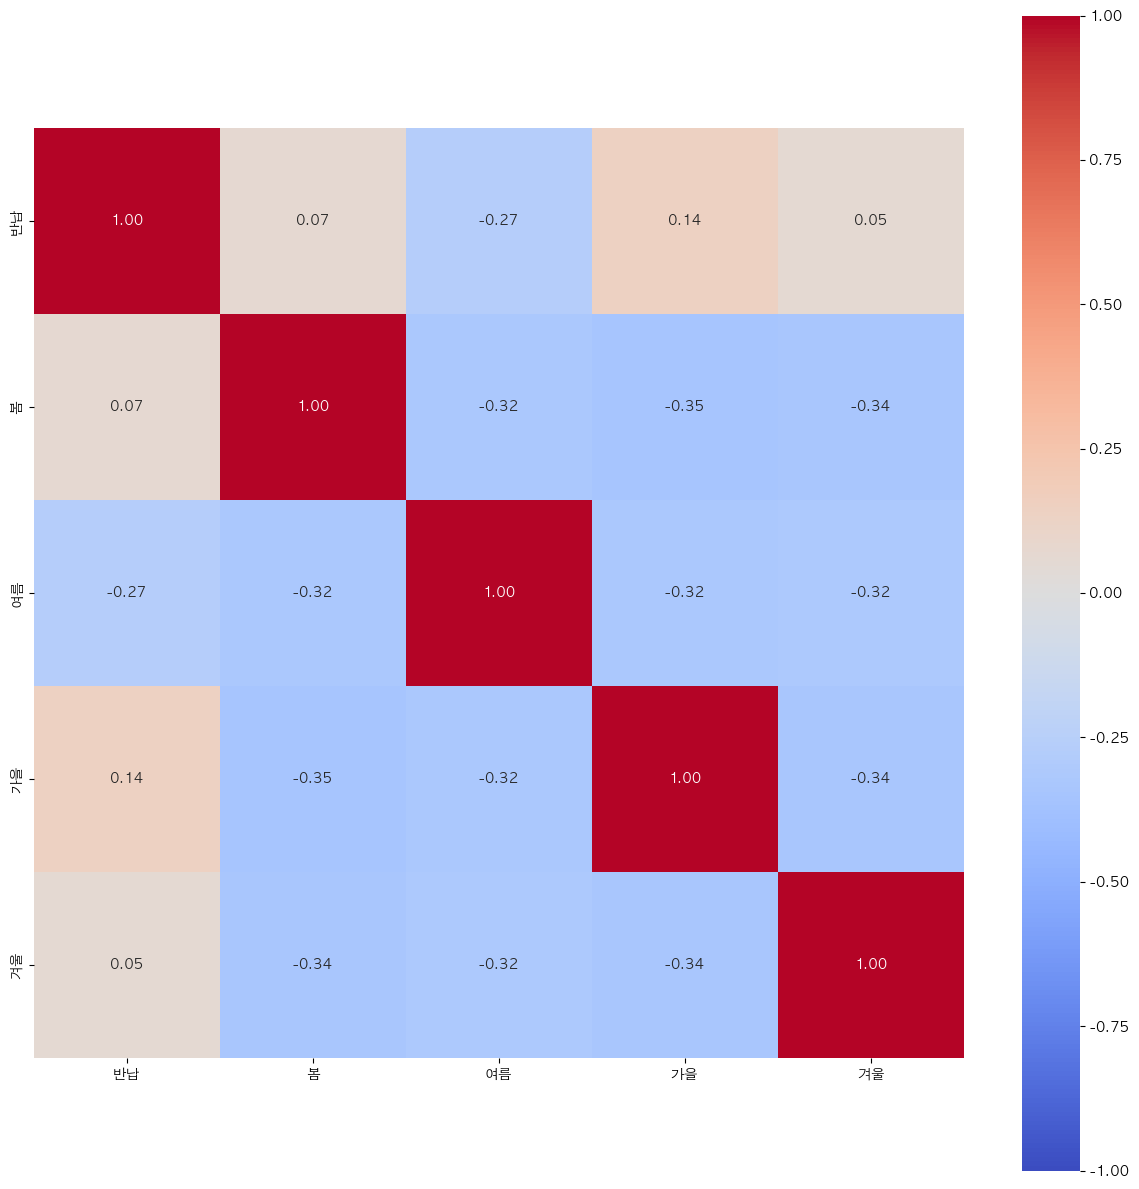

In [39]:
fig = plt.figure(figsize=(15,15))


sns.heatmap(return_count_weather[['반납','봄','여름','가을','겨울']].corr(),
            annot=True,  # 각 셀에 숫자 표시
            cmap='coolwarm',  # 색상 맵 설정
            vmin=-1, vmax=1,  # 색상 범위 설정
            center=0,  # 0을 중심으로 색상 대칭
            square=True,  # 정사각형 셀
            fmt='.2f', # 소수점 둘째 자리까지 표시
            ) 


plt.show()

In [40]:
conditions = [(rent_count_weather['강수량(mm)'] == 0), (rent_count_weather['강수량(mm)'] > 0)]
choices = ['맑음', '비']
rent_count_weather['강수여부']=np.select(conditions, choices, default='기타')
rent_count_weather[['맑음','비']]=pd.get_dummies(rent_count_weather['강수여부'])

In [41]:
conditions = [(return_count_weather['강수량(mm)'] == 0), (return_count_weather['강수량(mm)'] > 0)]
choices = ['맑음', '비']
return_count_weather['강수여부']=np.select(conditions, choices, default='기타')
return_count_weather[['맑음','비']]=pd.get_dummies(return_count_weather['강수여부'])

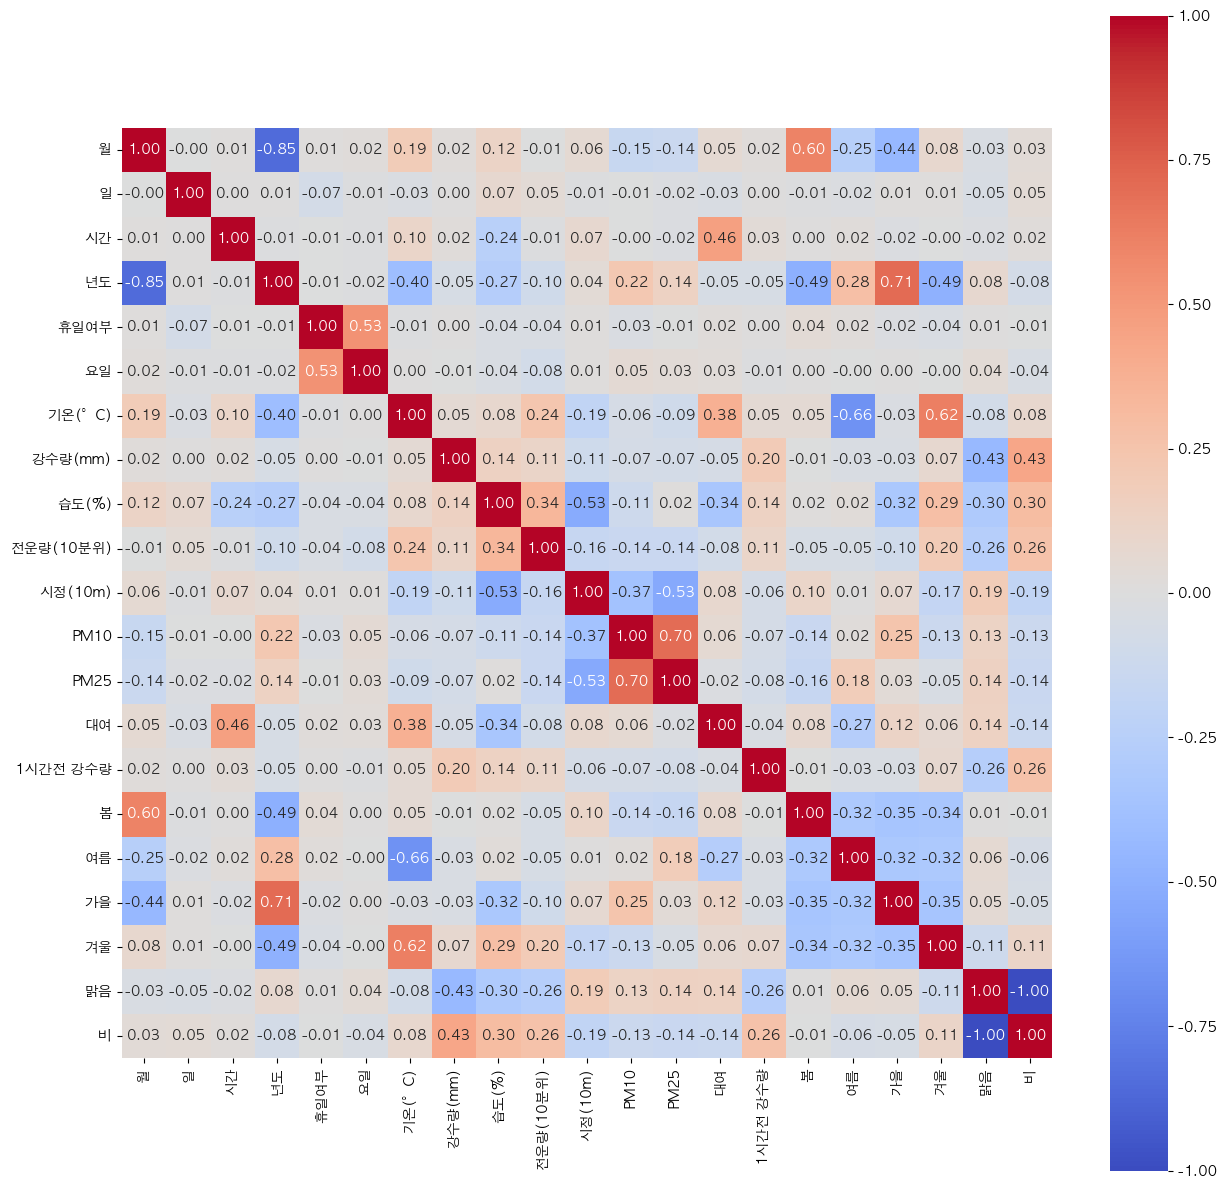

In [42]:
fig = plt.figure(figsize=(15,15))


sns.heatmap(rent_count_weather.corr(numeric_only=True),
            annot=True,  # 각 셀에 숫자 표시
            cmap='coolwarm',  # 색상 맵 설정
            vmin=-1, vmax=1,  # 색상 범위 설정
            center=0,  # 0을 중심으로 색상 대칭
            square=True,  # 정사각형 셀
            fmt='.2f', # 소수점 둘째 자리까지 표시
            ) 


plt.show()

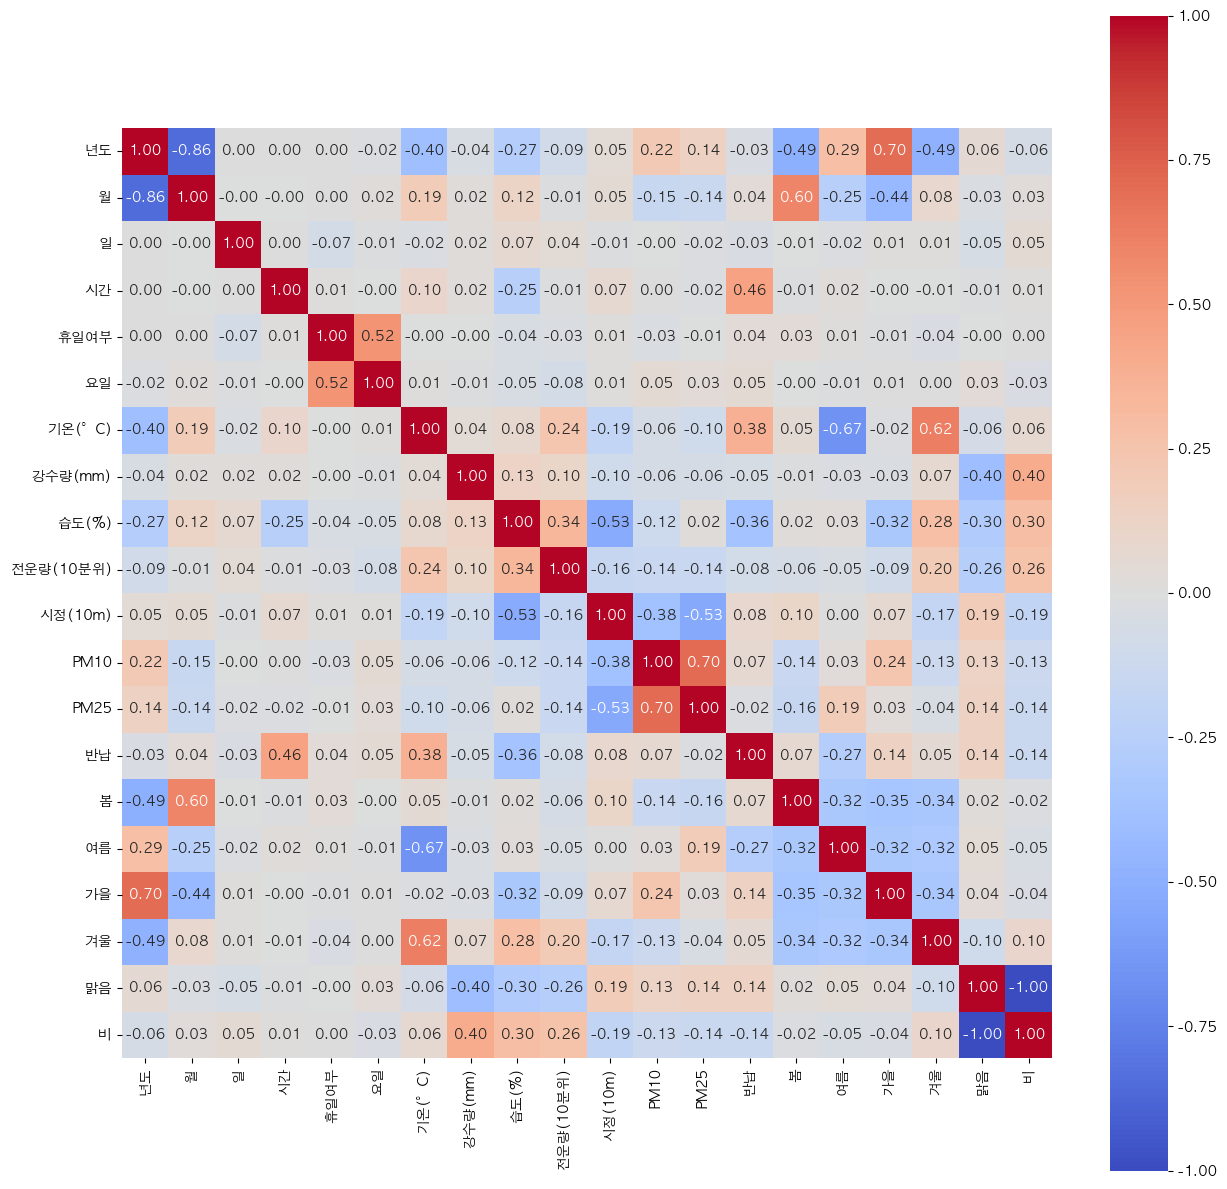

In [43]:
fig = plt.figure(figsize=(15,15))


sns.heatmap(return_count_weather.corr(numeric_only=True),
            annot=True,  # 각 셀에 숫자 표시
            cmap='coolwarm',  # 색상 맵 설정
            vmin=-1, vmax=1,  # 색상 범위 설정
            center=0,  # 0을 중심으로 색상 대칭
            square=True,  # 정사각형 셀
            fmt='.2f', # 소수점 둘째 자리까지 표시
            ) 


plt.show()

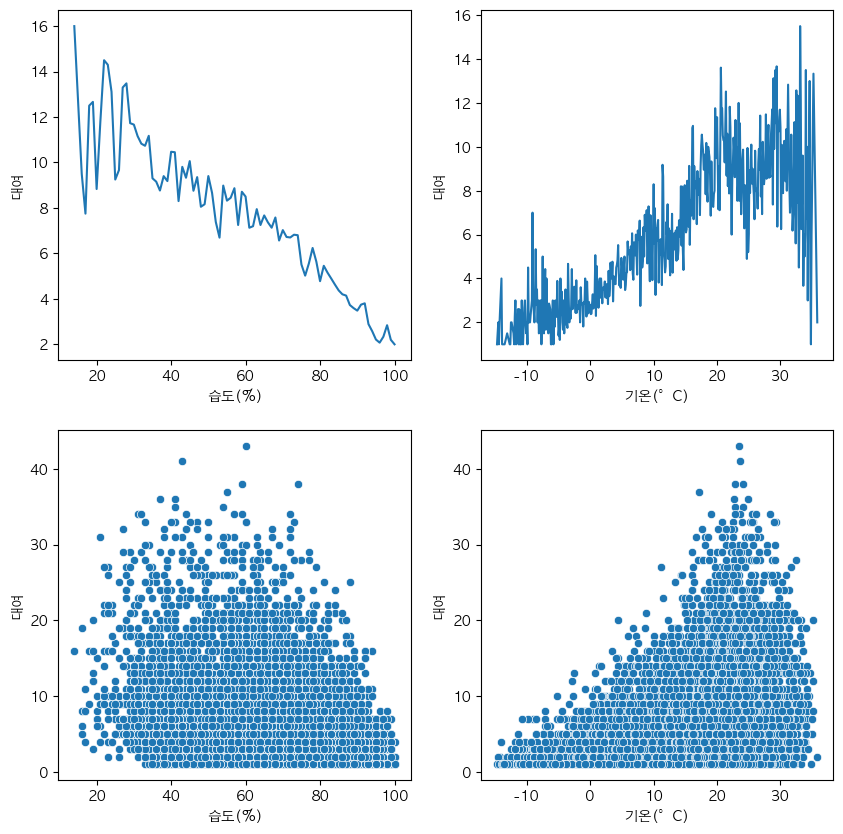

In [44]:
fig = plt.figure(figsize=(10,10))
ax1 = fig.add_subplot(2,2,1)
ax2 = fig.add_subplot(2,2,2)
ax3 = fig.add_subplot(2,2,3)
ax4 = fig.add_subplot(2,2,4)


### line
sns.lineplot(
    x='습도(%)',
    y='대여',
    data=rent_count_weather,
    ax=ax1,
    errorbar=None,
)

sns.lineplot(
    x='기온(°C)',
    y='대여',
    data=rent_count_weather,
    errorbar=None,
    ax=ax2
)


### scatter
sns.scatterplot(
    x='습도(%)',
    y='대여',
    data=rent_count_weather,
    ax=ax3,
)

sns.scatterplot(
    x='기온(°C)',
    y='대여',
    data=rent_count_weather,
    ax=ax4
)

plt.show()

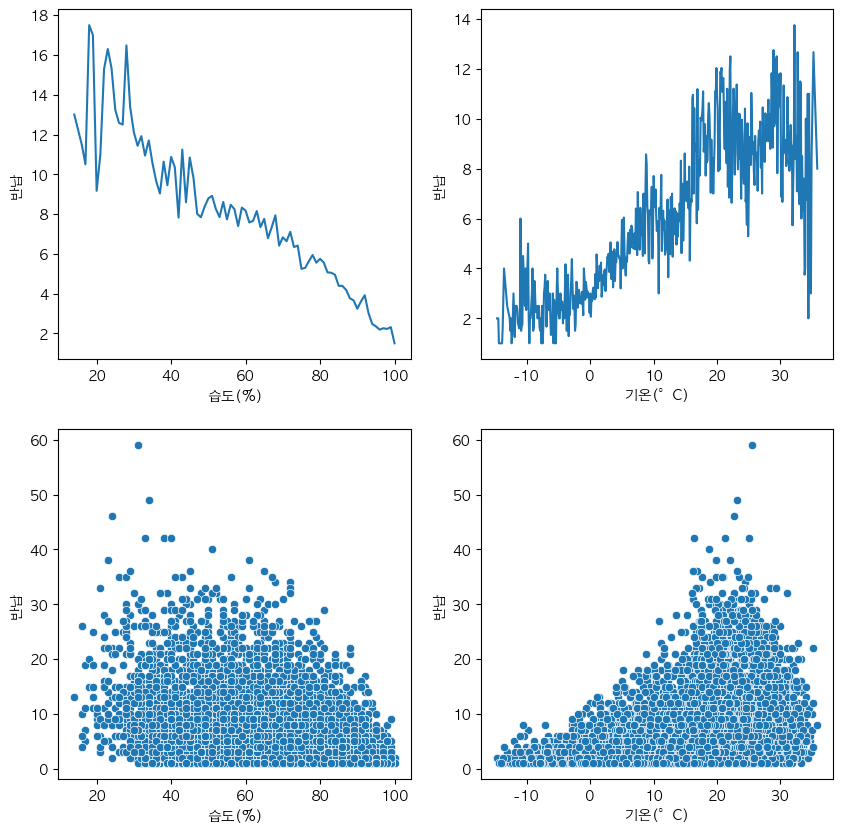

In [45]:
fig = plt.figure(figsize=(10,10))
ax1 = fig.add_subplot(2,2,1)
ax2 = fig.add_subplot(2,2,2)
ax3 = fig.add_subplot(2,2,3)
ax4 = fig.add_subplot(2,2,4)


### line
sns.lineplot(
    x='습도(%)',
    y='반납',
    data=return_count_weather,
    ax=ax1,
    errorbar=None,
)

sns.lineplot(
    x='기온(°C)',
    y='반납',
    data=return_count_weather,
    errorbar=None,
    ax=ax2
)


### scatter
sns.scatterplot(
    x='습도(%)',
    y='반납',
    data=return_count_weather,
    ax=ax3,
)

sns.scatterplot(
    x='기온(°C)',
    y='반납',
    data=return_count_weather,
    ax=ax4
)

plt.show()

In [46]:
rent_count_weather

,월,일,시간,년도,휴일여부,요일,기온(°C),강수량(mm),습도(%),전운량(10분위),...,대여,1시간전 강수량,계절,봄,여름,가을,겨울,강수여부,맑음,비
3100,6,1,1,2023,0,3,20.5,0.0,67,10,...,3,0.0,여름,False,False,False,True,맑음,True,False
3101,6,1,2,2023,0,3,20.4,0.0,69,10,...,2,0.0,여름,False,False,False,True,맑음,True,False
3102,6,1,3,2023,0,3,20.1,0.0,70,10,...,1,0.0,여름,False,False,False,True,맑음,True,False
3103,6,1,4,2023,0,3,20.2,0.0,70,10,...,1,0.0,여름,False,False,False,True,맑음,True,False
3104,6,1,5,2023,0,3,19.9,0.0,75,10,...,2,0.0,여름,False,False,False,True,맑음,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3095,5,31,19,2024,0,4,18.7,1.0,65,8,...,17,0.0,봄,False,False,True,False,비,False,True
3096,5,31,20,2024,0,4,18.4,0.0,68,8,...,11,1.0,봄,False,False,True,False,맑음,True,False
3097,5,31,21,2024,0,4,18.7,0.0,67,9,...,7,0.0,봄,False,False,True,False,맑음,True,False
3098,5,31,22,2024,0,4,18.8,0.0,73,10,...,22,0.0,봄,False,False,True,False,맑음,True,False


In [47]:
population=pd.read_csv('../../data/잠실동생활인구.csv')

In [48]:
population['기준일ID']=pd.to_datetime(population['기준일ID'].astype(str))
population.rename(columns={'시간대구분':'시간'},inplace= True)

In [49]:
population['년도'] =population['기준일ID'].dt.year
population['월'] =population['기준일ID'].dt.month
population['일'] =population['기준일ID'].dt.day

In [50]:
population.drop('기준일ID',axis= 1, inplace =True)

In [51]:
잠실본동=population[population['행정동코드'] ==11710650]
잠실2동=population[population['행정동코드'] ==11710670]
잠실3동=population[population['행정동코드'] ==11710680]
잠실4동=population[population['행정동코드'] ==11710690]
잠실6동=population[population['행정동코드'] ==11710710]
잠실7동=population[population['행정동코드'] ==11710720]

In [52]:
잠실본동.drop('행정동코드',axis=1, inplace =True)
잠실2동.drop('행정동코드',axis=1, inplace =True)
잠실3동.drop('행정동코드',axis=1, inplace =True)
잠실4동.drop('행정동코드',axis=1, inplace =True)
잠실6동.drop('행정동코드',axis=1, inplace =True)
잠실7동.drop('행정동코드',axis=1, inplace =True)

In [53]:

# fig = plt.figure(figsize=(30,30))


# sns.heatmap(pd.merge(rent_count_weather[['대여','시간','월','일','년도']], 잠실본동, on=['시간','월','일','년도']).corr(numeric_only=True),
#             annot=True,  # 각 셀에 숫자 표시
#             cmap='coolwarm',  # 색상 맵 설정
#             vmin=-1, vmax=1,  # 색상 범위 설정
#             center=0,  # 0을 중심으로 색상 대칭
#             square=True,  # 정사각형 셀
#             fmt='.2f', # 소수점 둘째 자리까지 표시
#             ) 
# plt.title('잠실본동',size = 90)

# plt.show()

In [54]:

# fig = plt.figure(figsize=(30,30))


# sns.heatmap(pd.merge(rent_count_weather[['대여','시간','월','일','년도']], 잠실2동, on=['시간','월','일','년도']).corr(numeric_only=True),
#             annot=True,  # 각 셀에 숫자 표시
#             cmap='coolwarm',  # 색상 맵 설정
#             vmin=-1, vmax=1,  # 색상 범위 설정
#             center=0,  # 0을 중심으로 색상 대칭
#             square=True,  # 정사각형 셀
#             fmt='.2f', # 소수점 둘째 자리까지 표시
#             ) 
# plt.title('잠실2동',size = 90)

# plt.show()

In [55]:

# fig = plt.figure(figsize=(30,30))


# sns.heatmap(pd.merge(rent_count_weather[['대여','시간','월','일','년도']], 잠실3동, on=['시간','월','일','년도']).corr(numeric_only=True),
#             annot=True,  # 각 셀에 숫자 표시
#             cmap='coolwarm',  # 색상 맵 설정
#             vmin=-1, vmax=1,  # 색상 범위 설정
#             center=0,  # 0을 중심으로 색상 대칭
#             square=True,  # 정사각형 셀
#             fmt='.2f', # 소수점 둘째 자리까지 표시
#             ) 

# plt.title('잠실3동',size = 90)
# plt.show()

In [56]:

# fig = plt.figure(figsize=(30,30))


# sns.heatmap(pd.merge(rent_count_weather[['대여','시간','월','일','년도']], 잠실4동, on=['시간','월','일','년도']).corr(numeric_only=True),
#             annot=True,  # 각 셀에 숫자 표시
#             cmap='coolwarm',  # 색상 맵 설정
#             vmin=-1, vmax=1,  # 색상 범위 설정
#             center=0,  # 0을 중심으로 색상 대칭
#             square=True,  # 정사각형 셀
#             fmt='.2f', # 소수점 둘째 자리까지 표시
#             ) 

# plt.title('잠실4동',size = 90)

# plt.show()

In [57]:

# fig = plt.figure(figsize=(30,30))


# sns.heatmap(pd.merge(rent_count_weather[['대여','시간','월','일','년도']], 잠실6동, on=['시간','월','일','년도']).corr(numeric_only=True),
#             annot=True,  # 각 셀에 숫자 표시
#             cmap='coolwarm',  # 색상 맵 설정
#             vmin=-1, vmax=1,  # 색상 범위 설정
#             center=0,  # 0을 중심으로 색상 대칭
#             square=True,  # 정사각형 셀
#             fmt='.2f', # 소수점 둘째 자리까지 표시
#             ) 

# plt.title('잠실6동', size = 90)

# plt.show()

In [58]:

# fig = plt.figure(figsize=(30,30))


# sns.heatmap(pd.merge(rent_count_weather[['대여','시간','월','일','년도']], 잠실7동, on=['시간','월','일','년도']).corr(numeric_only=True),
#             annot=True,  # 각 셀에 숫자 표시
#             cmap='coolwarm',  # 색상 맵 설정
#             vmin=-1, vmax=1,  # 색상 범위 설정
#             center=0,  # 0을 중심으로 색상 대칭
#             square=True,  # 정사각형 셀
#             fmt='.2f', # 소수점 둘째 자리까지 표시
#             ) 

# plt.title('잠실7동', size = 100)

# plt.show()

In [59]:
rent_df=pd.merge(rent_count_weather, 잠실3동, on=['시간','월','일','년도'])

In [60]:
# fig = plt.figure(figsize=(30,30))


# sns.heatmap(pd.merge(return_count_weather[['반납','시간','월','일','년도']], 잠실본동, on=['시간','월','일','년도']).corr(numeric_only=True),
#             annot=True,  # 각 셀에 숫자 표시
#             cmap='coolwarm',  # 색상 맵 설정
#             vmin=-1, vmax=1,  # 색상 범위 설정
#             center=0,  # 0을 중심으로 색상 대칭
#             square=True,  # 정사각형 셀
#             fmt='.2f', # 소수점 둘째 자리까지 표시
#             ) 
# plt.title('잠실본동',size = 90)

# plt.show()

In [61]:
# fig = plt.figure(figsize=(30,30))


# sns.heatmap(pd.merge(return_count_weather[['반납','시간','월','일','년도']], 잠실2동, on=['시간','월','일','년도']).corr(numeric_only=True),
#             annot=True,  # 각 셀에 숫자 표시
#             cmap='coolwarm',  # 색상 맵 설정
#             vmin=-1, vmax=1,  # 색상 범위 설정
#             center=0,  # 0을 중심으로 색상 대칭
#             square=True,  # 정사각형 셀
#             fmt='.2f', # 소수점 둘째 자리까지 표시
#             ) 
# plt.title('잠실2동',size = 90)

# plt.show()

In [62]:
# fig = plt.figure(figsize=(30,30))


# sns.heatmap(pd.merge(return_count_weather[['반납','시간','월','일','년도']], 잠실3동, on=['시간','월','일','년도']).corr(numeric_only=True),
#             annot=True,  # 각 셀에 숫자 표시
#             cmap='coolwarm',  # 색상 맵 설정
#             vmin=-1, vmax=1,  # 색상 범위 설정
#             center=0,  # 0을 중심으로 색상 대칭
#             square=True,  # 정사각형 셀
#             fmt='.2f', # 소수점 둘째 자리까지 표시
#             ) 
# plt.title('잠실3동',size = 90)

# plt.show()

In [63]:
# fig = plt.figure(figsize=(30,30))


# sns.heatmap(pd.merge(return_count_weather[['반납','시간','월','일','년도']], 잠실4동, on=['시간','월','일','년도']).corr(numeric_only=True),
#             annot=True,  # 각 셀에 숫자 표시
#             cmap='coolwarm',  # 색상 맵 설정
#             vmin=-1, vmax=1,  # 색상 범위 설정
#             center=0,  # 0을 중심으로 색상 대칭
#             square=True,  # 정사각형 셀
#             fmt='.2f', # 소수점 둘째 자리까지 표시
#             ) 
# plt.title('잠실4동',size = 90)

# plt.show()

In [64]:
# fig = plt.figure(figsize=(30,30))


# sns.heatmap(pd.merge(return_count_weather[['반납','시간','월','일','년도']], 잠실6동, on=['시간','월','일','년도']).corr(numeric_only=True),
#             annot=True,  # 각 셀에 숫자 표시
#             cmap='coolwarm',  # 색상 맵 설정
#             vmin=-1, vmax=1,  # 색상 범위 설정
#             center=0,  # 0을 중심으로 색상 대칭
#             square=True,  # 정사각형 셀
#             fmt='.2f', # 소수점 둘째 자리까지 표시
#             ) 
# plt.title('잠실6동',size = 90)

# plt.show()

In [65]:
# fig = plt.figure(figsize=(30,30))


# sns.heatmap(pd.merge(return_count_weather[['반납','시간','월','일','년도']], 잠실7동, on=['시간','월','일','년도']).corr(numeric_only=True),
#             annot=True,  # 각 셀에 숫자 표시
#             cmap='coolwarm',  # 색상 맵 설정
#             vmin=-1, vmax=1,  # 색상 범위 설정
#             center=0,  # 0을 중심으로 색상 대칭
#             square=True,  # 정사각형 셀
#             fmt='.2f', # 소수점 둘째 자리까지 표시
#             ) 
# plt.title('잠실7동',size = 90)

# plt.show()

> 반납 역시 잠실 3동 사용하기

In [66]:
return_df =pd.merge(return_count_weather, 잠실3동, on=['시간','월','일','년도'])



In [67]:
# return_df.to_csv('../../data/잠실새내인구반납.csv',index=False)
# rent_df.to_csv('../../data/잠실새내인구대여.csv',index=False)

In [68]:
# fig = plt.figure(figsize=(30,30))


# sns.heatmap(rent_df.corr(numeric_only=True),
#             annot=True,  # 각 셀에 숫자 표시
#             cmap='coolwarm',  # 색상 맵 설정
#             vmin=-1, vmax=1,  # 색상 범위 설정
#             center=0,  # 0을 중심으로 색상 대칭
#             square=True,  # 정사각형 셀
#             fmt='.2f', # 소수점 둘째 자리까지 표시
#             ) 

# plt.show()

In [69]:
rent_df.columns

Index(['월', '일', '시간', '년도', '휴일여부', '요일', '기온(°C)', '강수량(mm)', '습도(%)',
       '전운량(10분위)', '시정(10m)', 'PM10', 'PM25', '대여', '1시간전 강수량', '계절', '봄',
       '여름', '가을', '겨울', '강수여부', '맑음', '비', '총생활인구수', '남자0세부터9세생활인구수',
       '남자10세부터14세생활인구수', '남자15세부터19세생활인구수', '남자20세부터24세생활인구수',
       '남자25세부터29세생활인구수', '남자30세부터34세생활인구수', '남자35세부터39세생활인구수',
       '남자40세부터44세생활인구수', '남자45세부터49세생활인구수', '남자50세부터54세생활인구수',
       '남자55세부터59세생활인구수', '남자60세부터64세생활인구수', '남자65세부터69세생활인구수', '남자70세이상생활인구수',
       '여자0세부터9세생활인구수', '여자10세부터14세생활인구수', '여자15세부터19세생활인구수',
       '여자20세부터24세생활인구수', '여자25세부터29세생활인구수', '여자30세부터34세생활인구수',
       '여자35세부터39세생활인구수', '여자40세부터44세생활인구수', '여자45세부터49세생활인구수',
       '여자50세부터54세생활인구수', '여자55세부터59세생활인구수', '여자60세부터64세생활인구수',
       '여자65세부터69세생활인구수', '여자70세이상생활인구수'],
      dtype='object')

In [70]:
rent_df['남성2034생활인구']=rent_df[['남자20세부터24세생활인구수','남자25세부터29세생활인구수', '남자30세부터34세생활인구수',]].sum(axis=1)
return_df['남성2034생활인구']=return_df[['남자20세부터24세생활인구수','남자25세부터29세생활인구수', '남자30세부터34세생활인구수',]].sum(axis=1)

In [71]:
rent_df['남성2030생활인구']=rent_df[['남자20세부터24세생활인구수','남자25세부터29세생활인구수', '남자30세부터34세생활인구수','남자35세부터39세생활인구수']].sum(axis=1)
return_df['남성2030생활인구']=return_df[['남자20세부터24세생활인구수','남자25세부터29세생활인구수', '남자30세부터34세생활인구수','여자35세부터39세생활인구수']].sum(axis=1)

In [72]:
rent_df['여성2034생활인구']=rent_df[['여자20세부터24세생활인구수', '여자25세부터29세생활인구수', '여자30세부터34세생활인구수',]].sum(axis=1)
return_df['여성2034생활인구']=return_df[['여자20세부터24세생활인구수', '여자25세부터29세생활인구수', '여자30세부터34세생활인구수',]].sum(axis=1)

In [73]:
rent_df['여성2030생활인구']=rent_df[['여자20세부터24세생활인구수', '여자25세부터29세생활인구수', '여자30세부터34세생활인구수','여자35세부터39세생활인구수']].sum(axis=1)
return_df['여성2030생활인구']=return_df[['여자20세부터24세생활인구수', '여자25세부터29세생활인구수', '여자30세부터34세생활인구수','여자35세부터39세생활인구수']].sum(axis=1)

In [74]:
rent_df['2034생활인구']=rent_df['남성2034생활인구']+rent_df['여성2034생활인구']
return_df['2034생활인구']=return_df['남성2034생활인구']+return_df['여성2034생활인구']

In [75]:
rent_df['2030생활인구']=rent_df['남성2030생활인구']+rent_df['여성2030생활인구']
return_df['2030생활인구']=return_df['남성2030생활인구']+return_df['여성2030생활인구']

In [76]:
rent_df[['대여','2030생활인구','2034생활인구']].corr()
return_df[['반납','2030생활인구','2034생활인구']].corr()

,반납,2030생활인구,2034생활인구
반납,1.000000,0.491938,0.521990
2030생활인구,0.491938,1.000000,0.994249
2034생활인구,0.521990,0.994249,1.000000


In [77]:
rent_result=rent_df[['월', '일', '시간', '년도', '휴일여부', '요일', '기온(°C)','습도(%)',
        '전운량(10분위)', '시정(10m)', 'PM10', 'PM25', '대여' ,'계절','2030생활인구','2034생활인구']]

In [78]:
return_result=return_df[['월', '일', '시간', '년도', '휴일여부', '요일', '기온(°C)','습도(%)',
        '전운량(10분위)', '시정(10m)', 'PM10', 'PM25', '반납' ,'계절','2030생활인구','2034생활인구',]]

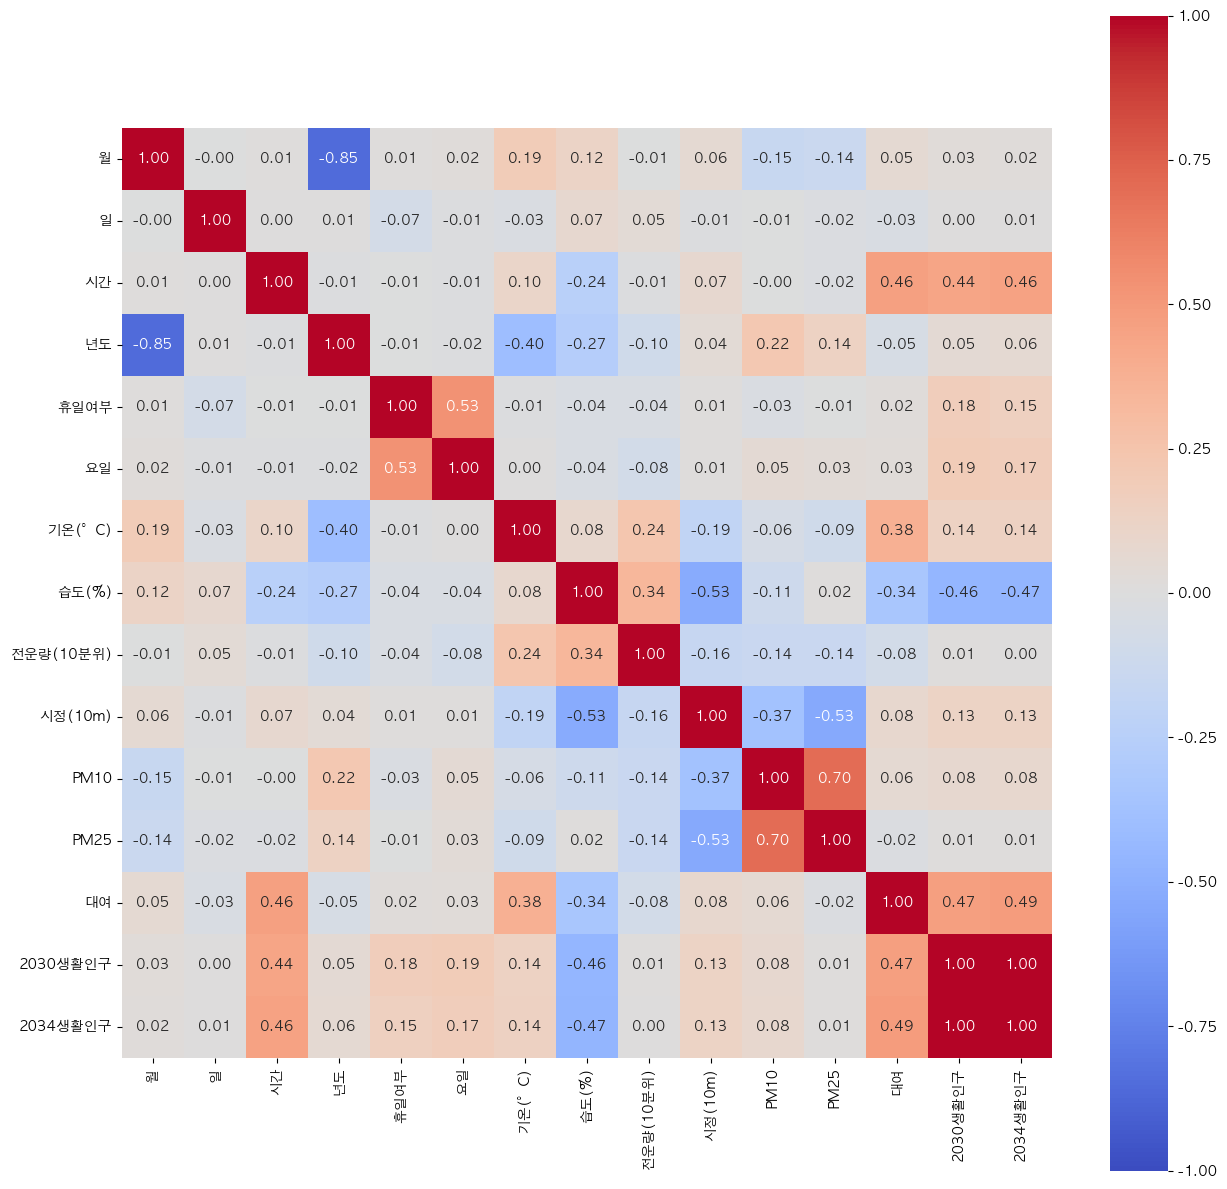

In [79]:
fig = plt.figure(figsize=(15,15))


sns.heatmap(rent_result.corr(numeric_only=True),
            annot=True,  # 각 셀에 숫자 표시
            cmap='coolwarm',  # 색상 맵 설정
            vmin=-1, vmax=1,  # 색상 범위 설정
            center=0,  # 0을 중심으로 색상 대칭
            square=True,  # 정사각형 셀
            fmt='.2f', # 소수점 둘째 자리까지 표시
            ) 

plt.show()

In [80]:
rent_result.head()

,월,일,시간,년도,휴일여부,요일,기온(°C),습도(%),전운량(10분위),시정(10m),PM10,PM25,대여,계절,2030생활인구,2034생활인구
0,6,1,1,2023,0,3,20.5,67,10,2000,39.0,24.0,3,여름,8525.0523,5408.0723
1,6,1,2,2023,0,3,20.4,69,10,2000,40.0,27.0,2,여름,8660.0855,5457.1553
2,6,1,3,2023,0,3,20.1,70,10,2000,39.0,24.0,1,여름,8685.6199,5536.7527
3,6,1,4,2023,0,3,20.2,70,10,2000,39.0,21.0,1,여름,8651.2341,5537.2119
4,6,1,5,2023,0,3,19.9,75,10,2000,39.0,24.0,2,여름,8746.4445,5589.9371


In [81]:
# rent_result=pd.merge(rent_result,rent_result.groupby(['월','시간','휴일여부'])['청장년층생활인구'].mean().reset_index(), on=['월','시간','휴일여부'])


In [82]:
# rent_result.rename(columns={'청장년층생활인구_x' : '청장년층생활인구합',
#        '청장년층생활인구_y' : '청년층 평균 생활인구'},inplace=True)

In [83]:
# return_result=pd.merge(return_result,return_result.groupby(['월','시간','휴일여부'])['청장년층생활인구'].mean().reset_index(), on=['월','시간','휴일여부'])

In [84]:
# return_result.rename(columns={'청장년층생활인구_x' : '청장년층생활인구합',
#        '청장년층생활인구_y' : '청년층 평균 생활인구'},inplace=True)

In [85]:
# rent_result.drop('청장년층생활인구합',axis=1, inplace=True)
# return_result.drop('청장년층생활인구합',axis=1, inplace=True)

In [86]:
return_result

,월,일,시간,년도,휴일여부,요일,기온(°C),습도(%),전운량(10분위),시정(10m),PM10,PM25,반납,계절,2030생활인구,2034생활인구
0,6,1,0,2023,0,3,20.7,66,10,2000,40.0,20.0,2,여름,9084.0466,5496.0700
1,6,1,1,2023,0,3,20.5,67,10,2000,39.0,24.0,2,여름,9008.5639,5408.0723
2,6,1,2,2023,0,3,20.4,69,10,2000,40.0,27.0,2,여름,9132.5951,5457.1553
3,6,1,3,2023,0,3,20.1,70,10,2000,39.0,24.0,1,여름,9092.9107,5536.7527
4,6,1,4,2023,0,3,20.2,70,10,2000,39.0,21.0,1,여름,9101.7907,5537.2119
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7492,5,31,19,2024,0,4,18.7,65,8,3671,17.0,4.0,20,봄,17404.1029,11782.1371
7493,5,31,20,2024,0,4,18.4,68,8,3216,10.0,1.0,21,봄,15233.6125,10316.7781
7494,5,31,21,2024,0,4,18.7,67,9,3449,13.0,4.0,14,봄,14121.0968,9482.1064
7495,5,31,22,2024,0,4,18.8,73,10,2528,16.0,11.0,8,봄,11842.9800,7913.8854


In [87]:
plt.scatter

<function matplotlib.pyplot.scatter(x: 'float | ArrayLike', y: 'float | ArrayLike', s: 'float | ArrayLike | None' = None, c: 'ArrayLike | Sequence[ColorType] | ColorType | None' = None, marker: 'MarkerType | None' = None, cmap: 'str | Colormap | None' = None, norm: 'str | Normalize | None' = None, vmin: 'float | None' = None, vmax: 'float | None' = None, alpha: 'float | None' = None, linewidths: 'float | Sequence[float] | None' = None, *, edgecolors: "Literal['face', 'none'] | ColorType | Sequence[ColorType] | None" = None, plotnonfinite: 'bool' = False, data=None, **kwargs) -> 'PathCollection'>

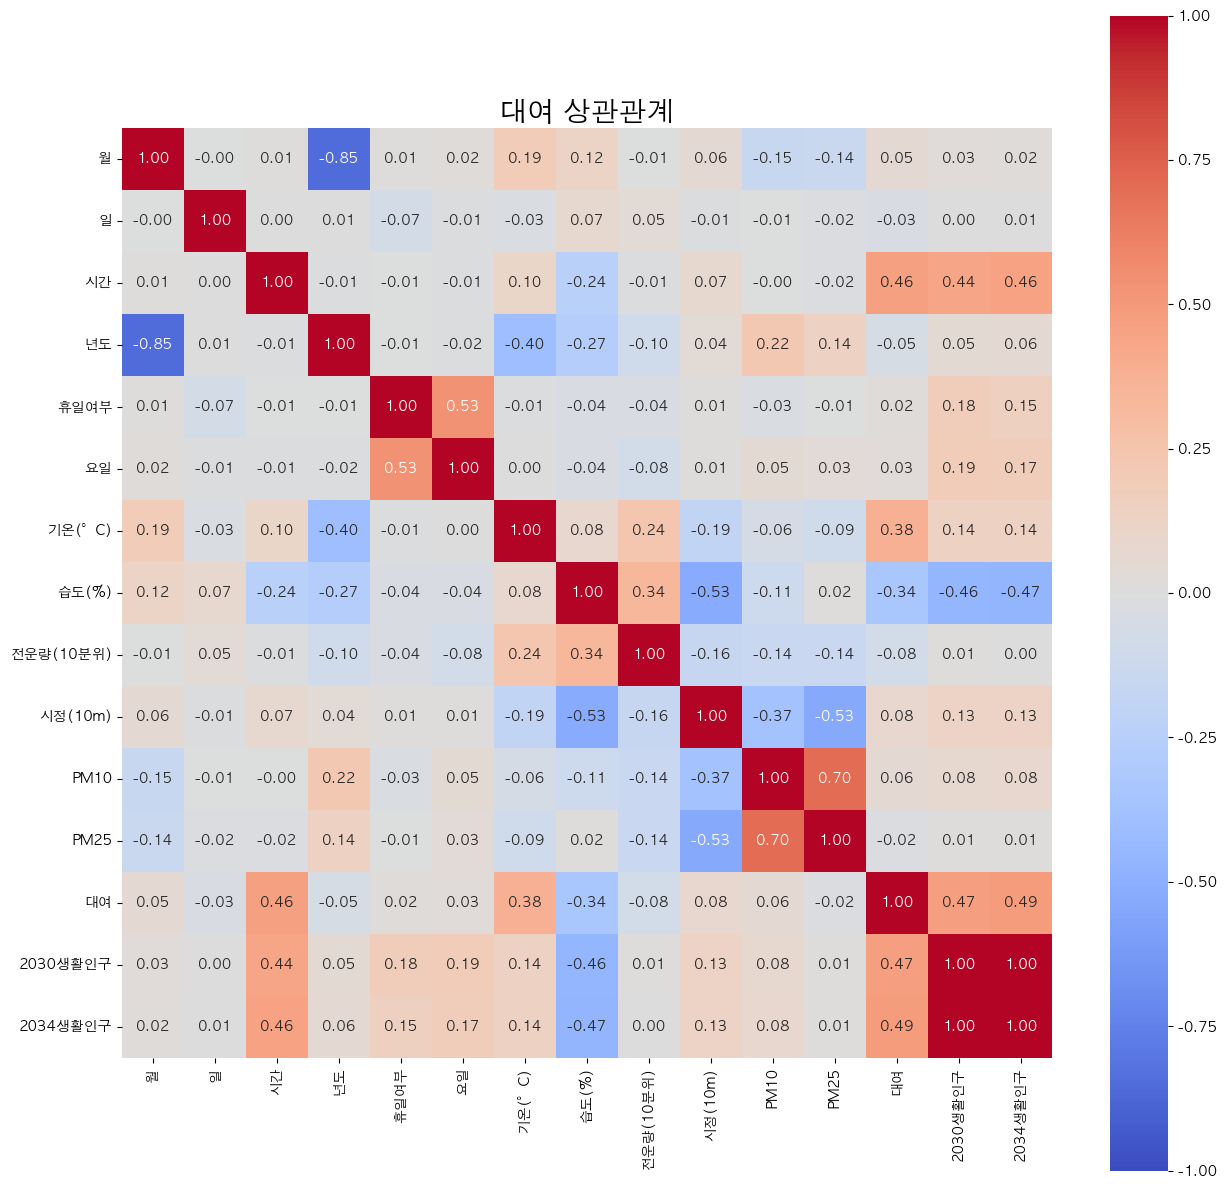

In [88]:
fig = plt.figure(figsize=(15,15))


sns.heatmap(rent_result.corr(numeric_only=True),
            annot=True,  # 각 셀에 숫자 표시
            cmap='coolwarm',  # 색상 맵 설정
            vmin=-1, vmax=1,  # 색상 범위 설정
            center=0,  # 0을 중심으로 색상 대칭
            square=True,  # 정사각형 셀
            fmt='.2f', # 소수점 둘째 자리까지 표시
            ) 


plt.title('대여 상관관계', size = 20)
plt.show()

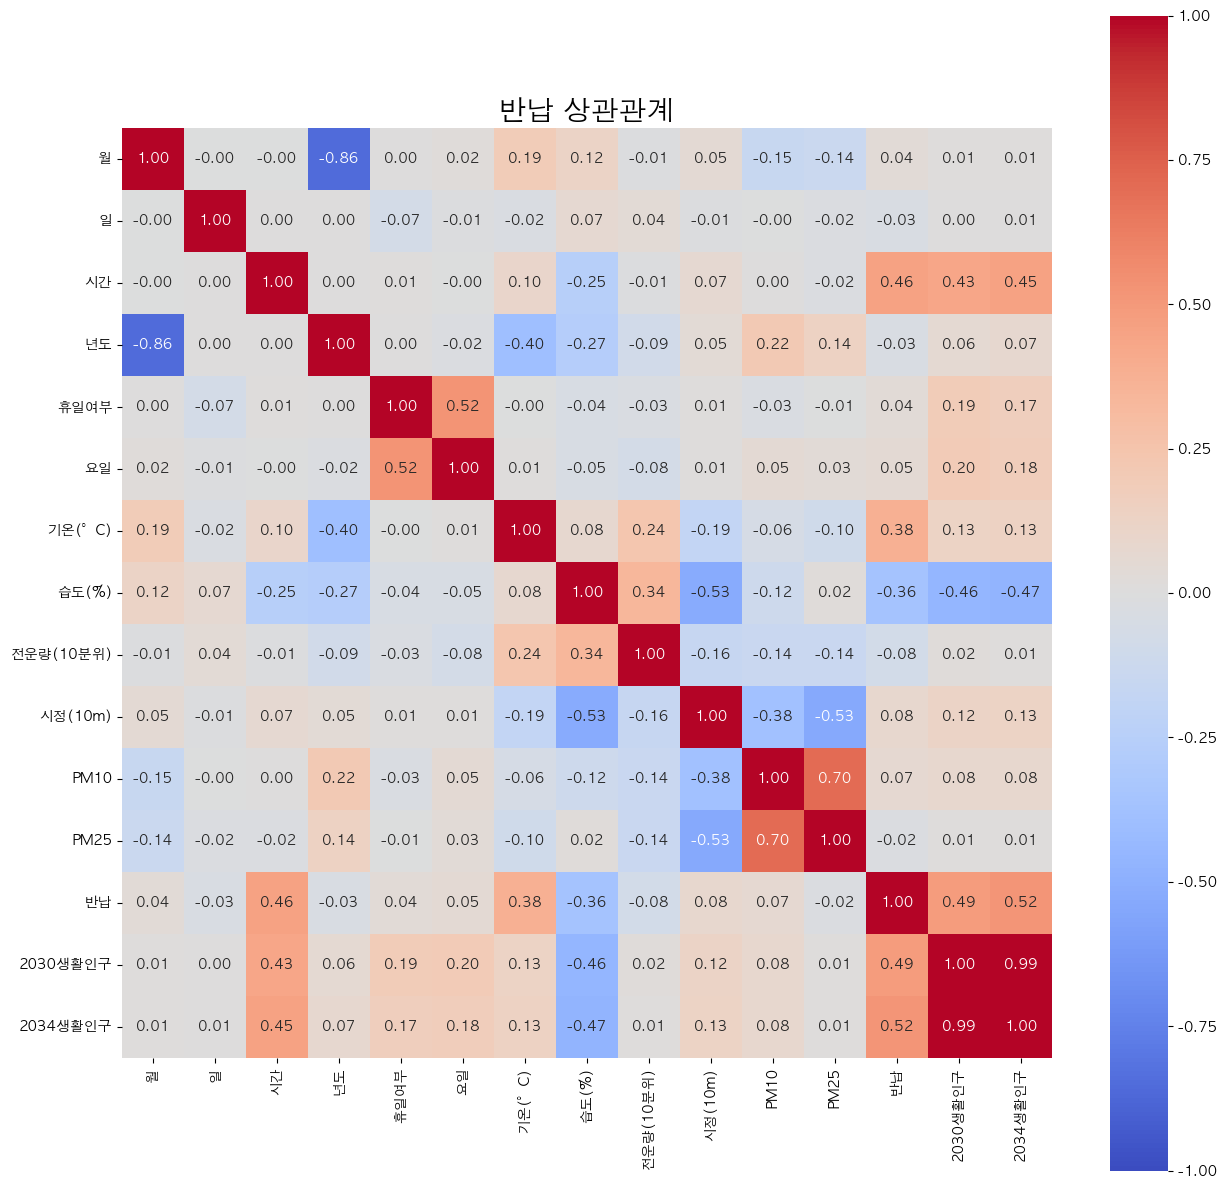

In [89]:
fig = plt.figure(figsize=(15,15))


sns.heatmap(return_result.corr(numeric_only=True),
            annot=True,  # 각 셀에 숫자 표시
            cmap='coolwarm',  # 색상 맵 설정
            vmin=-1, vmax=1,  # 색상 범위 설정
            center=0,  # 0을 중심으로 색상 대칭
            square=True,  # 정사각형 셀
            fmt='.2f', # 소수점 둘째 자리까지 표시
            ) 


plt.title('반납 상관관계', size = 20)
plt.show()

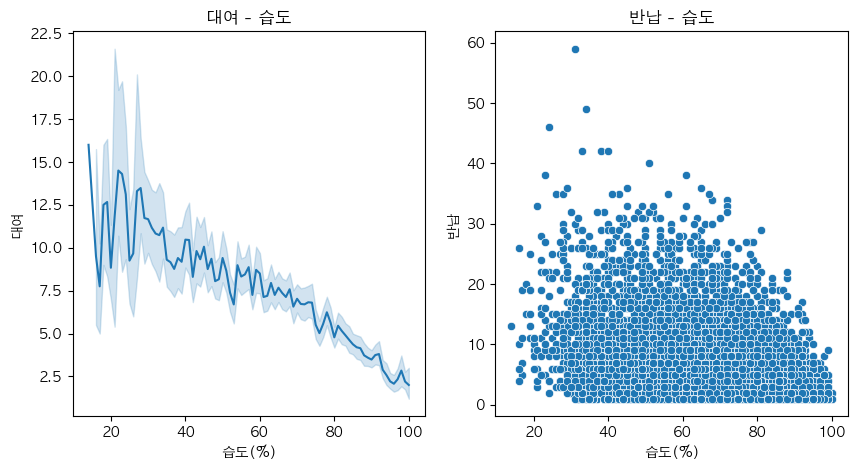

In [96]:
fig = plt.figure(figsize=(10,5))
ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)
sns.lineplot(
    x='습도(%)',
    y='대여',
    data= rent_result,
    ax=ax1
)
ax1.set_title('대여 - 습도')



sns.scatterplot(
    x='습도(%)',
    y='반납',
    data= return_result,
    ax=ax2
)
ax2.set_title('반납 - 습도')


plt.show()

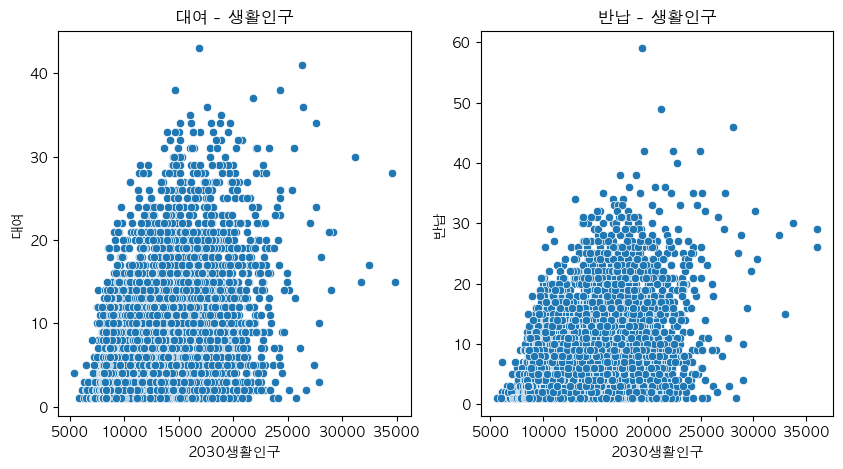

In [91]:
fig = plt.figure(figsize=(10,5))
ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)
sns.scatterplot(
    x='2030생활인구',
    y='대여',
    data= rent_result,
    ax=ax1
)
ax1.set_title('대여 - 생활인구')



sns.scatterplot(
    x='2030생활인구',
    y='반납',
    data= return_result,
    ax=ax2
)
ax2.set_title('반납 - 생활인구')


plt.show()

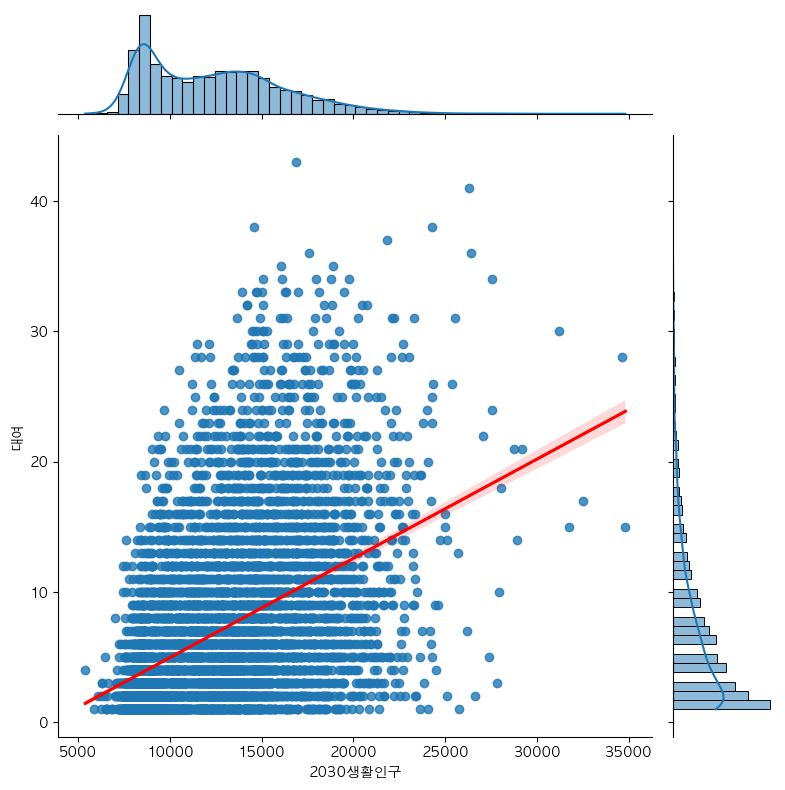

In [93]:

# Joint Plot (산점도와 분포를 동시에 보여줌)
sns.jointplot(data=rent_result, 
              x='2030생활인구', 
              y='대여',
              kind='reg',  # 회귀선 추가
            line_kws={'color':'red'},
              height=8)



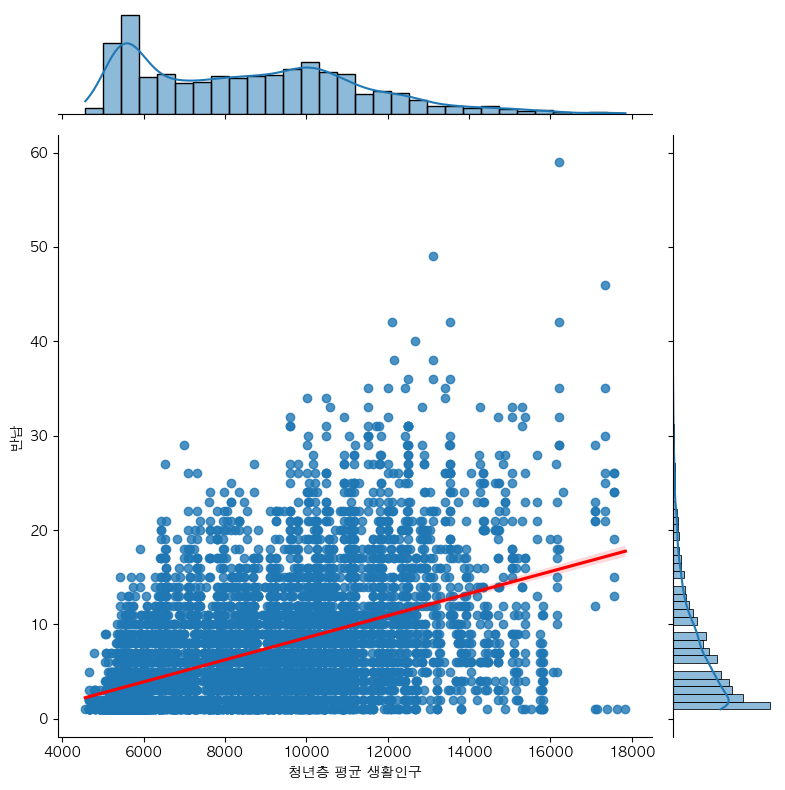

In [ ]:

# Joint Plot (산점도와 분포를 동시에 보여줌)
sns.jointplot(data=return_result, 
              x='청년층 평균 생활인구', 
              y='반납',
              kind='reg',  # 회귀선 추가
            line_kws={'color':'red'},
              height=8)

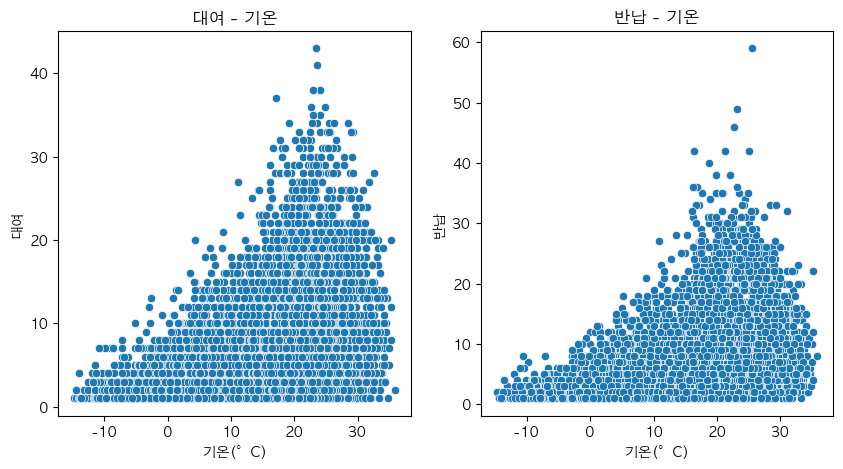

In [ ]:
fig = plt.figure(figsize=(10,5))
ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)
sns.scatterplot(
    x='기온(°C)',
    y='대여',
    data= rent_result,
    ax=ax1
)
ax1.set_title('대여 - 기온')



sns.scatterplot(
    x='기온(°C)',
    y='반납',
    data= return_result,
    ax=ax2
)
ax2.set_title('반납 - 기온')


plt.show()

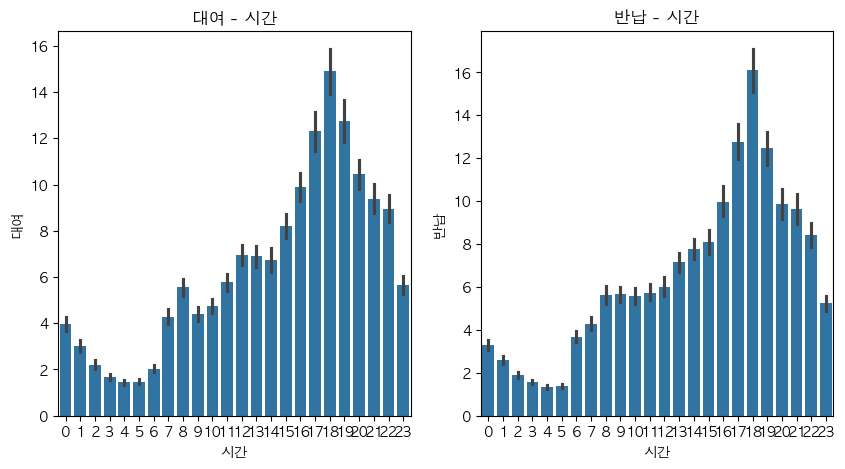

In [ ]:
fig = plt.figure(figsize=(10,5))
ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)

sns.barplot(
    x='시간',
    y='대여',
    data=rent_result,
    ax= ax1
)
ax1.set_title('대여 - 시간')

sns.barplot(
    x='시간',
    y='반납',
    data=return_result,
)
ax2.set_title('반납 - 시간')


plt.show()

In [ ]:
# rent_result.to_csv('../../data/잠실새내인구대여.csv',index=False)
# return_result.to_csv('../../data/잠실새내인구반납.csv',index=False)

-----------------------------
## 체크